# __Final Project__

This tutorial shows the basic steps of using SEP to detect objects in an image and perform some basic aperture photometry.

In [2]:
import numpy as np
import sep

In [3]:
# additional setup for reading the test image and displaying plots
import astropy.io
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline
rcParams['figure.figsize'] = [10., 8.]

First, we’ll read an example image from a FITS file and display it, just to show what we’re dealing with. The example image is just 256 x 256 pixels.

In [4]:
# opens the image
hdul = fits.open("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")

# extract the actual 2-D array
data = hdul[0].data

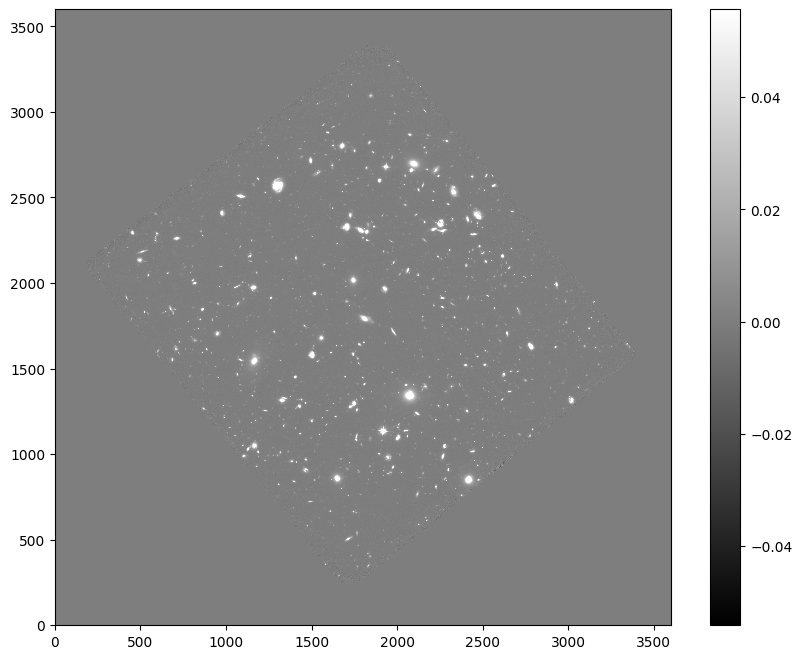

In [5]:
#show the image
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

# __Background subtraction__

In [6]:
#Byte-swap

# Copies data to a new array, preserves the ordering of the original array
new_data = data.astype(data.dtype.newbyteorder("="))
# The same outcome as the previous operation
new_data = data.byteswap()
new_data = new_data.view(new_data.dtype.newbyteorder("="))
# Changes data in-place
data = data.byteswap()
data = data.view(data.dtype.newbyteorder("="))

Most optical/IR data must be background subtracted before sources can be detected. In SEP, background estimation and source detection are two separate steps.

In [7]:
#measure a spatially varying background on the image
bkg = sep.Background(data)

This returns an Background object that holds information on the spatially varying background and spatially varying background noise level. We can now do various things with this Background object:

In [8]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


In [9]:
#evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
#bkg_image = np.array(bkg) #equivalent to above

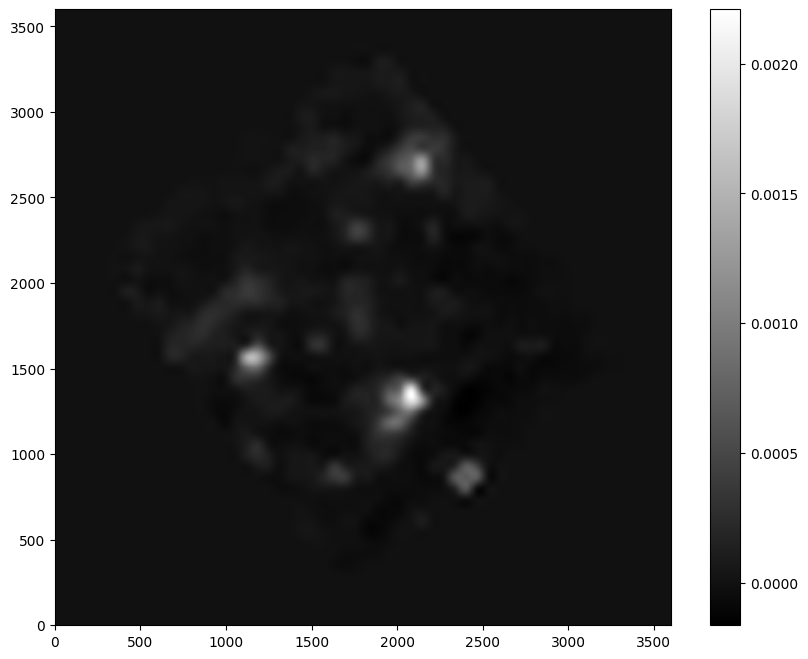

In [10]:
#show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();


In [11]:
# evalute the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

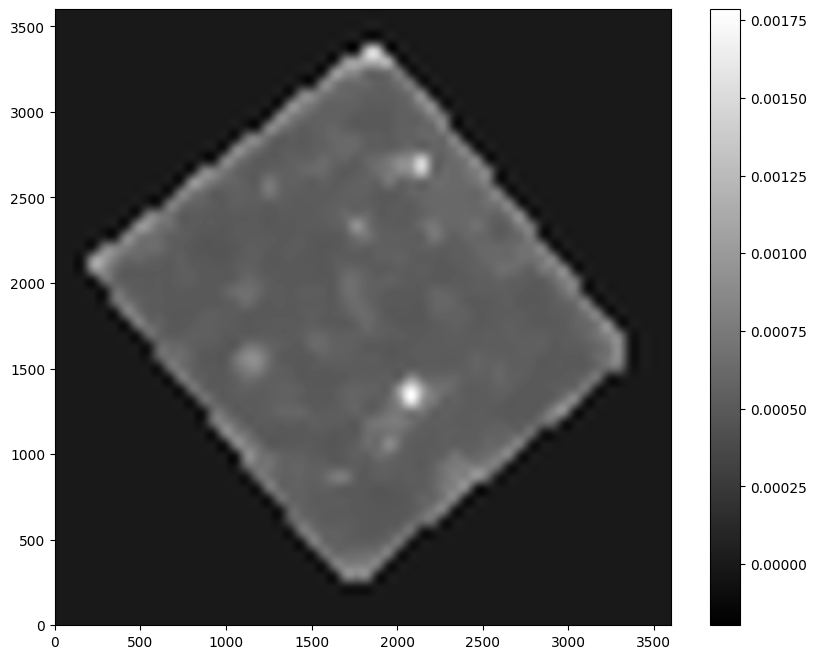

In [12]:
#show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

In [14]:
#subtract the background
data_sub = data - bkg

# __Object detection__

Now that we’ve subtracted the background, we can run object detection on the background-subtracted data. You can see the background noise level is pretty flat. So here we’re setting the detection threshold to be a constant value of 1.5 sigma where sigma is the global background RMS.

In [15]:
objects = sep.extract(data_sub, 3.0, err=bkg.globalrms)

In [16]:
#how many objects were detected
len(objects)

4342

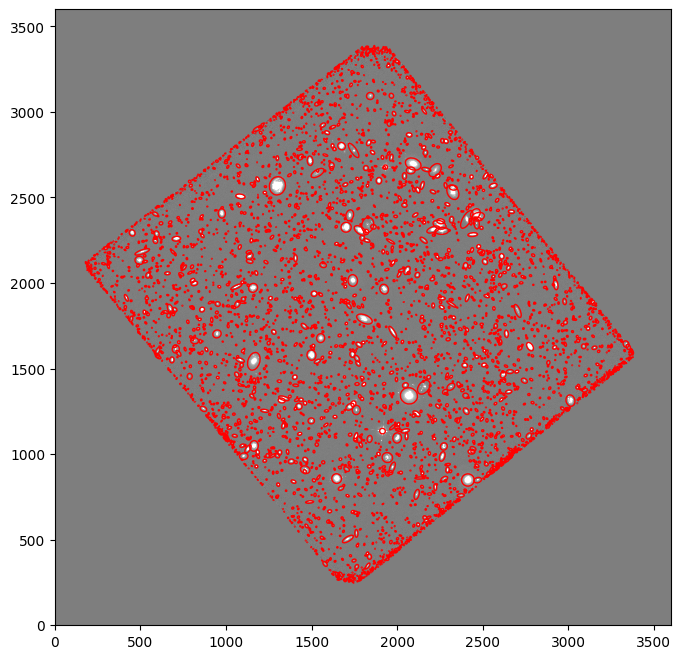

In [17]:
from matplotlib.patches import Ellipse

#plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', 
               vmin=m-s, vmax=m+s, origin='lower')

#plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

In [18]:
# available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

# __Aperture photometry__

Finally, we’ll perform simple circular aperture photometry with a 3 pixel radius at the locations of the objects:

In [19]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [20]:
#show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.029831 +/- 0.172742
object 1: flux = 0.085622 +/- 0.292626
object 2: flux = 0.026933 +/- 0.164137
object 3: flux = 0.046099 +/- 0.214727
object 4: flux = 0.064379 +/- 0.253747
object 5: flux = 0.070986 +/- 0.266448
object 6: flux = 0.026083 +/- 0.161527
object 7: flux = 0.104682 +/- 0.323559
object 8: flux = 0.044953 +/- 0.212041
object 9: flux = 0.042711 +/- 0.206686


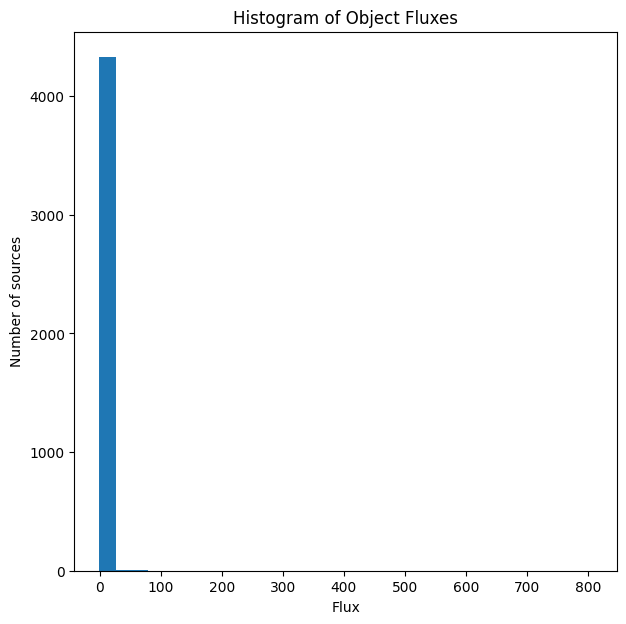

In [22]:
#Histogram the fluxes
plt.figure(figsize=(7,7))
plt.hist(flux, bins=30)
plt.xlabel("Flux")
plt.ylabel("Number of sources")
plt.title("Histogram of Object Fluxes")
plt.show()

In [23]:
#Find the mean, median, and std of the distribution of fluxes
mean = np.mean(flux)
median = np.median(flux)
std = np.std(flux)

print("mean =", mean)
print("median =", median)
print("std =", std)

mean = 0.7051371042509809
median = 0.07393474855838578
std = 13.02881115333335


In [24]:
#Find the largest outlier in the distribution
max_flux = np.max(flux)
max_index = np.argmax(flux)

print("Largest flux:", max_flux)
print("Index of that source:", max_index)

x_outlier = objects['x'][max_index]
y_outlier = objects['y'][max_index]

print("Outlier location (x, y):", x_outlier, y_outlier)

Largest flux: 807.1093853378296
Index of that source: 982
Outlier location (x, y): 1914.258065243131 1134.3147121031375


<Figure size 600x600 with 0 Axes>

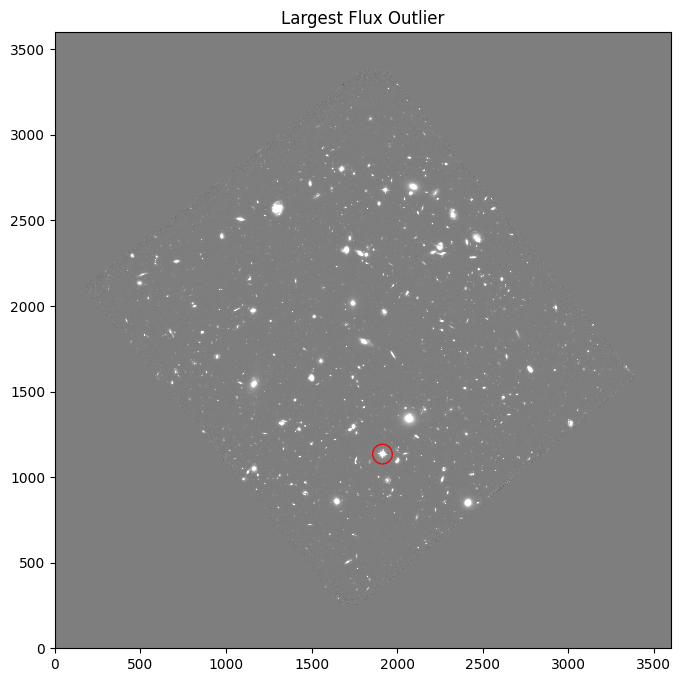

In [25]:
#Find the largest outlier on the image
plt.figure(figsize=(6,6))

fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', 
               vmin=m-s, vmax=m+s, origin='lower')

plt.scatter(x_outlier, y_outlier, facecolors='none', edgecolors='red', s=200)
plt.title("Largest Flux Outlier")
plt.show()

In [26]:
std_from_mean = (max_flux - mean) / std
print("Outlier is", std_from_mean, "standard deviations above the mean.")

Outlier is 61.893924068986486 standard deviations above the mean.
